<a href="https://colab.research.google.com/github/gpdsec/Object-Detection/blob/main/HardHat_detection_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive







##### **Installing importent Libraries**

In [ ]:
!pip install pyyaml==5.1

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


     |████████████████████████████████| 274 kB 8.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=b60a001fa1475f87c41e58ecfaced527f33d86a6d1286482de6c45f90a8b1fbd
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
     |████████████████████████████████| 6.4 MB 2.0 MB/s 
     |████████████████████████████████| 130 kB 9.4 MB/s 
     |████████████████████████████████| 144 kB 14.0 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 743 kB 17.3 MB/s 
     |████████████████████████████████| 722 kB 37.2 MB/s 
     |███

##### **Importing libraries**

In [ ]:
# importing pytorch
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import copy
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
from glob import glob

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode


#### **Unziping Train Data and Registering data**

In [ ]:
!unzip -qq -o /content/drive/MyDrive/Data/HardHat_Dataset.zip

In [ ]:

def get_HardHat_dicts():    
    dataset_dicts = []
    doc_paths = glob('HardHat_Dataset/annotations/*.xml')
    for idx, xml_file in enumerate(doc_paths):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        record = {}
        objs = []
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text
            if label == "helmet":
              category_id = 0
            else:
              category_id = 1


            obj = {"bbox": [xmin, ymin, xmax, ymax],
                   "bbox_mode": BoxMode.XYXY_ABS,
                   "category_id": category_id,
                   "label": label
                  }
            objs.append(obj)

        filename = root.find('filename').text   
        record["file_name"] =  "HardHat_Dataset/images/" + filename
        record["image_id"] = idx
        record["height"] = int(root.find('size')[1].text)
        record["width"] = int(root.find('size')[0].text)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts





In [ ]:
data = {}
dataset = get_HardHat_dicts()
data["train"] = dataset[:4745]
data["val"] = dataset[4745:]

def get_data(data):
  return data


In [ ]:
# Registering Data
for d in ["train", "val"]:
  DatasetCatalog.register("HardHat_" + d, lambda d=d: get_data(data[d]))
  MetadataCatalog.get("HardHat_" + d).set(thing_classes=["Hardhat", "head"])
Hardhat_metadata = MetadataCatalog.get("HardHat_train")

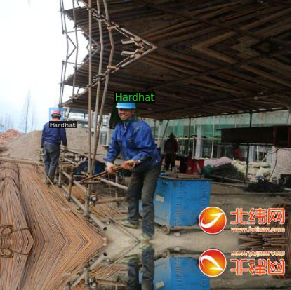

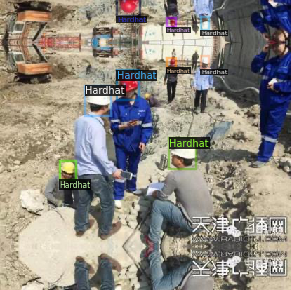

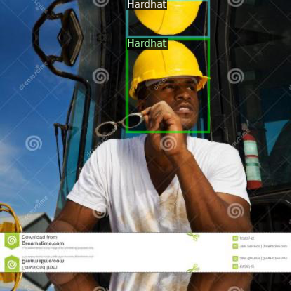

In [ ]:
# visualizing data
dataset_dicts = data["train"]
for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  #print(d["annotations"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=Hardhat_metadata, scale=0.7)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

##### **Training Model**

In [ ]:

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("HardHat_train",)
cfg.DATASETS.TEST = ("HardHat_val",)
#cfg.SOLVER.CHECKPOINT_PERIOD = 20
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001 
cfg.SOLVER.MAX_ITER = 2000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/18 20:42:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in th

[08/18 20:42:27 d2.engine.train_loop]: Starting training from iteration 0
[08/18 20:42:40 d2.utils.events]:  eta: 0:21:21  iter: 19  total_loss: 1.978  loss_cls: 1.378  loss_box_reg: 0.382  loss_rpn_cls: 0.1913  loss_rpn_loc: 0.04596  time: 0.6227  data_time: 0.0380  lr: 1.9981e-05  max_mem: 3901M
[08/18 20:42:52 d2.utils.events]:  eta: 0:21:00  iter: 39  total_loss: 1.753  loss_cls: 1.121  loss_box_reg: 0.427  loss_rpn_cls: 0.1954  loss_rpn_loc: 0.03943  time: 0.6193  data_time: 0.0218  lr: 3.9961e-05  max_mem: 3901M
[08/18 20:43:05 d2.utils.events]:  eta: 0:20:50  iter: 59  total_loss: 1.632  loss_cls: 0.8155  loss_box_reg: 0.5493  loss_rpn_cls: 0.119  loss_rpn_loc: 0.06196  time: 0.6240  data_time: 0.0200  lr: 5.9941e-05  max_mem: 3901M
[08/18 20:43:18 d2.utils.events]:  eta: 0:20:43  iter: 79  total_loss: 1.397  loss_cls: 0.6264  loss_box_reg: 0.6765  loss_rpn_cls: 0.06822  loss_rpn_loc: 0.03129  time: 0.6301  data_time: 0.0233  lr: 7.9921e-05  max_mem: 3901M
[08/18 20:43:31 d2.uti

##### **Loading Best Model & Prediction**

In [ ]:
# Chossing Best Model

import json  
with open('/content/output/metrics.json') as f:
  json_data = f.readlines()
jsonlist = []
for idx, d in enumerate(json_data):
  mt = json.loads(d)
  jsonlist.append(mt)
  if idx==0:
    loss_cls = mt['loss_cls']
    loss_box_reg = mt['loss_box_reg']
    iteration = mt['iteration']
  elif mt['loss_cls']<=loss_cls and mt['loss_box_reg']<=loss_box_reg:
    loss_cls = mt['loss_cls']
    loss_box_reg = mt['loss_box_reg']
    iteration = mt['iteration']


print(f"Best model at iteration : {iteration}")



Best model at iteration : 19


In [ ]:
#### loading best model
#cfg = get_cfg()
#cfg.MODEL.DEVICE='cpu'
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
#best_model = "model_000"+str(iteration)+".pth"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')  # path to the model we just trained
#cfg.MODEL.WEIGHTS = os.path.join('/content/drive/MyDrive/Models/', '/content/output/model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
# Saving Best Model
#model = build_model(cfg)
#torch.save(model, 'HardHat.pth') 
#model = torch.load('HardHat.pth')

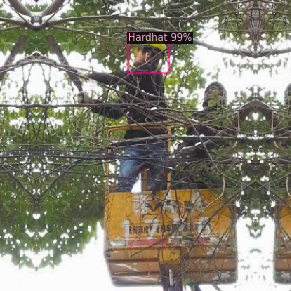

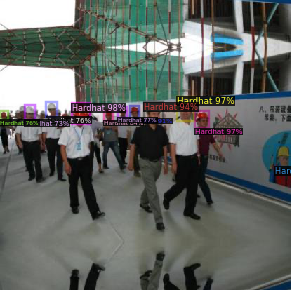

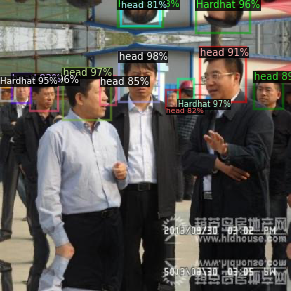

In [ ]:
# Predicting and Visulizing Best model on validation data
for imageName in random.sample(data["val"], 3):
  im = cv2.imread(imageName["file_name"])
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=Hardhat_metadata, 
                scale=0.7
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])




##### **Predecting on testing Data**

In [ ]:
!unzip -qq -o /content/drive/MyDrive/Data/HardHat_Test_Images.zip

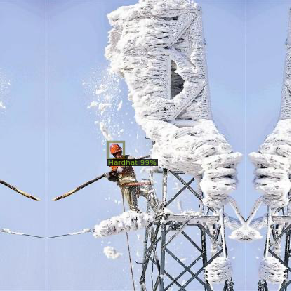

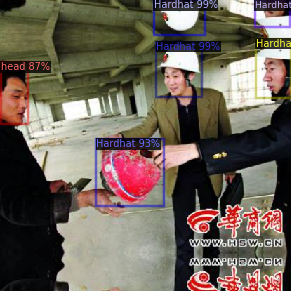

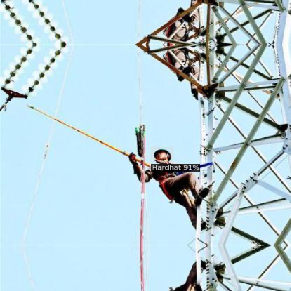

In [ ]:
testData = glob("/content/Images/*.png")
for imageName in random.sample(testData, 3):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=Hardhat_metadata, 
                scale=0.7
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# function to draw box
# function to draw box
def drawbox(image, bbox, score, cls):
  (width, height, depth) = image.shape
  font_scale = max(float(np.sqrt((bbox[2]-bbox[0])*((bbox[3]-bbox[1])))/260), 0.3)
  thickness = max(int(font_scale*3), 1)

  label = cls +" "+ score +"%"

  cp_y = int(bbox[1]+(bbox[3]-bbox[1])*1/4)
  cp_x = int(bbox[0]+(bbox[2]-bbox[0])/3)
  colorpix = image[cp_y][cp_x]
  color = (int(colorpix[0]), int(colorpix[1]), int(colorpix[2]))
  
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[2]), int(bbox[3]))
  image = cv2.rectangle(image, p1, p2, color, 1, 1)
  (text_width, text_height) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
  box_coords = ((p1[0], p1[1]+text_height +2), (p1[0] + text_width + 2, p1[1] - 2))
  image = cv2.rectangle(image, box_coords[0], box_coords[1], (0, 0, 0), cv2.FILLED)
  image = cv2.putText(image, label, (p1[0], p1[1]+text_height), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)

  return image




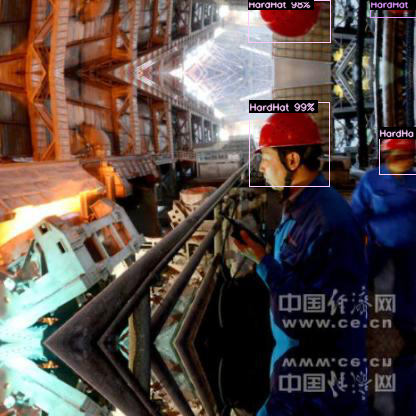

In [ ]:
labellist = ["HardHat", "Head"]
resultdicts = []
for i, imageName in enumerate(testData):
  image = cv2.imread(imageName)
  outputs = predictor(image)
  outputs = outputs["instances"].to('cpu')
  boxes = outputs.pred_boxes
  scores = outputs.scores
  classes = outputs.pred_classes.tolist()
  record = {}
  objs = []
  token = imageName.split("/")
  path = "/content/drive/MyDrive/Data/Test_images/"+token[-1]
  for idx, box in enumerate(boxes):
    cls = labellist[int(classes[idx])]
    score = str(int(float(scores[idx])*100))
    bbox = (float(box[0]), float(box[1]), float(box[2]), float(box[3]))
    image = drawbox(image, bbox, score, cls)
    obj = {}
    obj['label'] = cls
    obj['score'] = score
    obj['bbox'] = bbox
    objs.append(obj)  
    
  cv2_imshow(image)
  break  
  
  record["filename"] = token[-1]
  record['path'] = imageName
  record["size"] = image.shape
  record["objects"] = objs
  resultdicts.append(record)
  cv2.imwrite(path, image)
  
  print(f"{i} was successful")
    

  

##### **Creating XML file**

In [ ]:
# function for xml file
def write_to_xml(datadict, xml_template='pascal_voc_template.xml'):
    
    labellist = ["HardHat", 'Head']
    # get bboxes
    objects = datadict["objects"]
    
    # read xml file
    tree = ET.parse(xml_template)
    root = tree.getroot()    
    
    # modify
    folder = root.find('folder')
    folder.text = 'test_xml'

    path = root.find("path")
    path.text =  datadict["path"]
    
    fname = root.find('filename')
    fname.text =datadict["filename"]
    
    src = root.find('source')
    database = src.find('database')
    database.text = 'Unknown'
    
    (h,w,d) = datadict["size"]
    
    size = root.find('size')
    width = size.find('width')
    width.text =  str(w)
    height = size.find('height')
    height.text = str(w)
    depth = size.find('depth')
    depth.text = str(d)
    
    for objec in objects:
        # append object
        box = objec['bbox']
        obj = ET.SubElement(root, 'object')

        
        name = ET.SubElement(obj, 'label')
        name.text = objec['label']

        score = ET.SubElement(obj, 'score')
        score.text = objec['label']
        
        pose = ET.SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = ET.SubElement(obj, 'truncated')
        truncated.text = str(0)

        difficult = ET.SubElement(obj, 'difficult')
        difficult.text = str(0)

        bndbox = ET.SubElement(obj, 'bndbox')
        
        xmin = ET.SubElement(bndbox, 'xmin')
        xmin.text = str(int(box[0]))
        
        ymin = ET.SubElement(bndbox, 'ymin')
        ymin.text = str(int(box[1]))
        
        xmax = ET.SubElement(bndbox, 'xmax')
        xmax.text = str(int(box[2]))
        
        ymax = ET.SubElement(bndbox, 'ymax')
        ymax.text = str(int(box[3]))
    
    # save .xml to anno_path
    tok = datadict["filename"].split(".")[0]
    anno_path = "/content/drive/MyDrive/Data/Test_xml_result/" + tok + '.xml'
    with open (anno_path, "wb") as files :
        tree.write(files)

In [ ]:
# writing xml files
for items in resultdicts:
  write_to_xml(items)

print("*****Finished*****")

*****Finished*****


##### **Inference with Video**

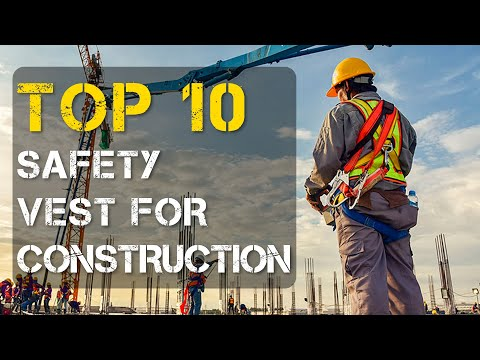

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("6PoPwZ0WO9w", width=500)
display(video)

In [ ]:
# Install dependencies, download the video
#!pip install youtube-dl
#!youtube-dl https://www.youtube.com/watch?v=6PoPwZ0WO9w -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:10 -c:v copy video-clip.mp4 ## for testing algo

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
video_path = "video.mp4"
video = cv2.VideoCapture(video_path)
ret, frame = video.read()
fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(3))
frame_height = int(video.get(4))
size = (frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
filename = "/content/drive/MyDrive/Data/Processed Video2.mp4"
out = cv2.VideoWriter(filename, fourcc, fps, size)
while True:
  ret, frame = video.read()
  if not ret:
            break
  outputs = predictor(frame)
  outputs = outputs["instances"].to('cpu')
  boxes = outputs.pred_boxes
  scores = outputs.scores
  classes = outputs.pred_classes.tolist()
  #print(frame.shape)
  for idx, box in enumerate(boxes):
    cls = labellist[int(classes[idx])]
    score = str(int(float(scores[idx])*100))
    bbox = (float(box[0]), float(box[1]), float(box[2]), float(box[3]))
    frame = drawbox(frame, bbox, score, cls)
  out.write(frame)
print("*****inferencing finished*****")
video.release()
out.release()



*****inferencing finished*****
